In [1]:
import numpy as np
import random
random.seed(7)
from gridworld import *

In [2]:
NUM_RUNS = 10
MAX_NUM_STEPS_PER_EPISODE = 10000
NUM_EPISODES = 20000
STEP_SIZE = 0.001
TARGET_POLICY = (
    {"up": 0, "down": 0, "right": 0, "left": 0}, # Terminal state
    {"up": 0, "down": 0, "right": 0, "left": 1},
    {"up": 0, "down": 0, "right": 0, "left": 1},
    {"up": 0, "down": 0, "right": 0, "left": 1},
    {"up": 1, "down": 0, "right": 0, "left": 0},
    {"up": 1, "down": 0, "right": 0, "left": 0},
    {"up": 1, "down": 0, "right": 0, "left": 0},
    {"up": 0, "down": 1, "right": 0, "left": 0},
    {"up": 1, "down": 0, "right": 0, "left": 0},
    {"up": 0, "down": 1, "right": 0, "left": 0},
    {"up": 0, "down": 1, "right": 0, "left": 0},
    {"up": 0, "down": 1, "right": 0, "left": 0},
    {"up": 0, "down": 0, "right": 1, "left": 0},
    {"up": 0, "down": 0, "right": 1, "left": 0},
    {"up": 0, "down": 0, "right": 1, "left": 0}
)
environment = Environment()
results = []

In [3]:
def compute_importance_sampling_ratio(target_policy, states, actions, tau, n, T):
    importance_sampling_ratio = 1
    for i in range(tau, min(tau + n, T - 1)):
        # 0.25 is the probability of all actions under the uniform random policy
        importance_sampling_ratio *= target_policy[states[i]][actions[i]] / 0.25 
    return importance_sampling_ratio

In [4]:
# Using the uniform random policy as behavior policy
def run_n_step_td_off_policy(environment, target_policy, num_episodes, max_num_steps_per_episode, step_size, n):
    V = np.zeros(len(environment.transitions))
    rms_error_per_episode = np.zeros(num_episodes)
    for ep in range(num_episodes):
        states = [environment.generate_random_start_state()]
        actions = []
        rewards = []
        T = np.inf
        for t in range(max_num_steps_per_episode):
            if t < T:
                action = random.choice(environment.available_actions)
                reward, new_state, reached_terminal_state = environment.take_action(states[t], action)
                actions.append(action)
                rewards.append(reward)
                states.append(new_state)
                if reached_terminal_state:
                    T = t + 1
            tau = t - n + 1
            if tau >= 0:
                importance_sampling_ratio = compute_importance_sampling_ratio(target_policy, states, actions, tau, n, T)
                G = np.sum(rewards[tau:min(tau + n, T)])
                if tau + n < T:
                    G = G + V[states[tau + n]]
                V[states[tau]] += step_size * importance_sampling_ratio * (G - V[states[tau]])
            if tau == T - 1:
                break
        rms_error_per_episode[ep] = compute_rms_error(V)
    return V, rms_error_per_episode

In [5]:
# n-step TD off-policy (n=3)
rms_error_per_episode_sum = np.zeros(NUM_EPISODES)
for run in range(NUM_RUNS):
    V, rms_error_per_episode = run_n_step_td_off_policy(environment, TARGET_POLICY, NUM_EPISODES, MAX_NUM_STEPS_PER_EPISODE, STEP_SIZE, 3)
    rms_error_per_episode_sum += rms_error_per_episode
results.append(rms_error_per_episode_sum / NUM_RUNS)
V

array([ 0.        , -0.99366415, -1.99889273, -2.99941854, -0.99335245,
       -1.99710258, -2.99759589, -1.99837963, -1.99844329, -2.99871837,
       -1.99663941, -0.99305328, -2.99785256, -1.99827922, -0.99302542])

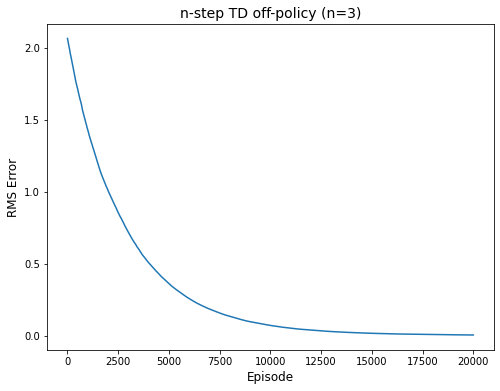

In [6]:
plot_progress(results[0], (8, 6), "n-step TD off-policy (n=3)")